## Spectral Regularization
### Under review as a conference paper at ICLR 2020

All dependencies are open-source and available on Pypi:
* [numba](https://pypi.org/project/numba/) (optional, for code accelaration only)
* [numpy](https://pypi.org/project/numpy/)
* [pandas](https://pypi.org/project/pandas/) (optional, for display of the results only)
* [scipy](https://pypi.org/project/scipy/)
* [scikit-learn](https://pypi.org/project/scikit-learn/)
* [scikit-network](https://pypi.org/project/scikit-network/)

In [1]:
from decimal import Decimal

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn import metrics
from sklearn.cluster import KMeans

from sknetwork.clustering import modularity
from sknetwork.embedding import Spectral, SVD
from sknetwork.toy_graphs import block_model

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Toy case

In [4]:
blocks = np.zeros((10, 10))
blocks[0:5, 0:5] = 1
blocks[5:8, 5:8] = 1
blocks[8:, 8:] = 1

α_1 = 0.1
α_2 = 1.

In [5]:
def mu(x, α=1.):
    x = abs(x)
    return 1 / (1 + x / α)

In [6]:
spc = Spectral(embedding_dimension=2, regularization=None, relative_regularization=False, scaling=None).fit(blocks)
spc.embedding_

array([[ 0.06562174,  0.00455692],
       [ 0.06562174,  0.00455692],
       [ 0.06562174,  0.00455692],
       [ 0.06562174,  0.00455692],
       [ 0.06562174,  0.00455692],
       [ 0.31408609, -0.0262799 ],
       [ 0.31408609, -0.0262799 ],
       [ 0.31408609, -0.0262799 ],
       [ 0.03351883,  0.49831345],
       [ 0.03351883,  0.49831345]])

In [7]:
spc.regularization = α_1
spc.fit(blocks)
eigvals_1 = spc.eigenvalues_

In [8]:
spc.regularization = α_2
spc.fit(blocks)
eigvals_2 = spc.eigenvalues_
spc.embedding_

array([[ 0.07563759,  0.01912882],
       [ 0.07563759,  0.01912882],
       [ 0.07563759,  0.01912882],
       [ 0.07563759,  0.01912882],
       [ 0.07563759,  0.01912882],
       [-0.11427685,  0.07304416],
       [-0.11427685,  0.07304416],
       [-0.11427685,  0.07304416],
       [-0.05066758, -0.17847433],
       [-0.05066758, -0.17847433]])

In [9]:
eigvals_1, eigvals_2

(array([0.21517576, 0.30982424]), array([0.72481921, 0.81364233]))

In [10]:
intervals_1 = mu(np.array([5, 3, 2]) / 10, α_1)
intervals_2 = mu(np.array([5, 3, 2]) / 10, α_2)

In [11]:
intervals_1, intervals_2

(array([0.16666667, 0.25      , 0.33333333]),
 array([0.66666667, 0.76923077, 0.83333333]))

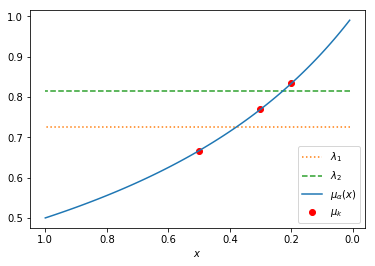

In [12]:
x = np.linspace(1e-2, 1, 100)
fig, ax = plt.subplots()

ax.plot(x, eigvals_2[0] * np.ones(x.shape[0]), label=r'$\lambda_1$', linestyle='dotted', c='tab:orange')
ax.plot(x, eigvals_2[1] * np.ones(x.shape[0]), label=r'$\lambda_2$', linestyle='dashed', c='tab:green')
ax.plot(x, mu(x, α_2), label=r'$\mu_{\alpha}(x)$', c='tab:blue')
ax.scatter([0.5, 0.3, 0.2], intervals_2, c='r', label=r'$\mu_k$')

ax.set_xlabel(r'$x$')
ax.invert_xaxis()
ax.legend()
plt.savefig('intervals.pdf', format='pdf')
plt.show()

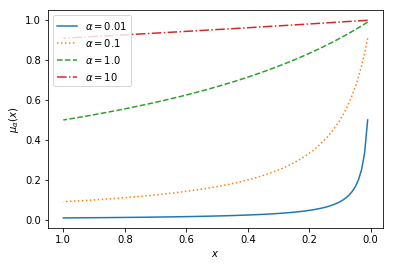

In [13]:
fig, ax = plt.subplots()

ax.plot(x, mu(x, 0.01), label=r'$\alpha = 0.01$', linestyle='solid')
ax.plot(x, mu(x, 0.1), label=r'$\alpha = 0.1$', linestyle='dotted')
ax.plot(x, mu(x, 1.0), label=r'$\alpha = 1.0$', linestyle='dashed')
ax.plot(x, mu(x, 10.), label=r'$\alpha = 10$', linestyle='dashdot')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\mu_{\alpha}(x)$')
ax.invert_xaxis()
ax.legend(loc='upper left')
plt.savefig('mu.pdf', format='pdf')
plt.show()

## Metrics

In [14]:
def norm_sdt(labels: np.ndarray) -> float:
    """Normalized standard deviation.
    """
    n = labels.shape[0]
    counts = np.unique(labels, return_counts=True)[1]
    k = counts.shape[0]
    return 1 - np.std(counts) / np.sqrt(n**2 * (k - 1) / k**2)

In [15]:
def all_metrics(adjacency, labels: np.ndarray, labels_true: np.ndarray) -> dict:
    """Compute all the clustering metrics and store the output in a dictionary.
    """
    n_labels = len(set(labels))
        
    output = {}
    output['ARI'] = metrics.adjusted_rand_score(labels_pred=labels, labels_true=labels_true)
    h, c, v = metrics.homogeneity_completeness_v_measure(labels_pred=labels, labels_true=labels_true)
    output['H'] = h
    output['C'] = c
    output['V'] = v
    output['AMI'] = metrics.adjusted_mutual_info_score(labels_pred=labels, labels_true=labels_true, average_method='arithmetic')
    output['FMI'] = metrics.fowlkes_mallows_score(labels_pred=labels, labels_true=labels_true)
    if adjacency.shape[0] == adjacency.shape[1]:
        output['Q'] = modularity(adjacency, labels, force_undirected=True)
    else:
        features_degrees = sparse.diags(adjacency.T.dot(np.ones(adjacency.shape[0])), format='csr')
        features_degrees.data = 1 / features_degrees.data
        output['Q'] = modularity(adjacency.dot(features_degrees).dot(adjacency.T), labels, force_undirected=True)
    output['std'] = norm_sdt(labels)
    
    return output

In [16]:
def display_results(results):
    """Display the results in a DataFrame
    """
    df = pd.DataFrame(index=results.keys(), columns=['H', 'C', 'V', 'ARI', 'AMI', 'FMI', 'Q', 'std'], dtype=float)
    
    for algo, res in results.items():
        for key, item in res.items():
            df.at[algo, key] = item
    return df.round(2)

In [17]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_df(df):
    return df.style.apply(highlight_max)

### Setting all hyper-parameters

In [18]:
# embedding dimension
n_dim = 20
# alpha values
α_vals = [0., 1e-4, 1e-3, 1e-2, 1e-1, 1., 10.]
α_strs = ['%.0E' % Decimal(str(val)) for val in α_vals]

#noise values
noise_vals = [0., 0.01, 0.05, 0.1]

# block model parameters
inner_prob = 0.4
outer_prob = 0.01
shapes = np.array([(i, i) for i in range(1, 101)])

## Experiments

In [19]:
# use option "solver='halko'" for faster but less accurate embeddings.
spectral = Spectral(embedding_dimension=n_dim, solver='lanczos', scaling=None)
svd = SVD(embedding_dimension=n_dim, solver='lanczos', scaling=None)

In [20]:
def add_noise(adjacency, fraction: float):
    """
    Add isolated nodes to an adjacency matrix or isolated pairs to a biadjacency matrix.
    """
    n_samples = adjacency.shape[0]
    n_outliers = int(fraction * n_samples)
    
    return sparse.bmat([[adjacency, None], [None, sparse.eye(n_outliers, format='csr')]], format='csr')

In [21]:
def get_all_scores(algo, adjacency, labels_true, n_clusters, α_vals=α_vals, noise=0.):
    """
    Compute all scores on a given dataset.
    """
    
    n_true = len(set(labels_true))
    if type(n_clusters)==int:
        n_clusters = [n_clusters]
    if type(α_vals)==float:
        α_vals = [α_vals]
        
    results = {key: {} for key in n_clusters}
        
    for i, α in enumerate(α_vals):
        α_key = '%.0E' % Decimal(str(α))
        algo.regularization = α
        algo.fit(add_noise(adjacency, noise))
        
        for k in n_clusters:
            km = KMeans(n_clusters=k)
            max_dim = min(algo.embedding_dimension, k)
            km.fit(algo.embedding_[:, :max_dim])
            
            scores_ = all_metrics(adjacency, km.labels_[:len(labels_true)], labels_true)
            results[k][α_key] = scores_        
    
    return results

In [22]:
def test_noise(algo, adjacency, labels_true, n_clusters, α=1., noise_vals=noise_vals):
    α_key = '%.0E' % Decimal(str(α))
    results = {}
    
    for noise in noise_vals:
        results[noise] = get_all_scores(algo, adjacency, labels_true, n_clusters, α, noise)[n_clusters][α_key]
    
    return results

In [23]:
def undir_vs_bipartite(biadjacency, labels_true, n_clusters, α=1.):
    results = {key: {} for key in n_clusters}
    
    n_true = len(set(labels_true))
    if type(n_clusters)==int:
        n_clusters = [n_clusters]
        
    spectral.regularization = α
    spectral.fit(biadjacency)
    svd.regularization = α
    svd.fit(biadjacency)
    
    for k in n_clusters:
        km = KMeans(n_clusters=k)
        max_dim = min(svd.embedding_dimension, k)
        
        km.fit(spectral.embedding_[:, :max_dim])
        results[k]['A'] = all_metrics(biadjacency, km.labels_[:len(labels_true)], labels_true)
        km.fit(svd.embedding_[:, :max_dim])
        results[k]['B'] = all_metrics(biadjacency, km.labels_[:len(labels_true)], labels_true)

    return results

### Stochastique Block Model

In [24]:
sbm, sbm_truth, _ = block_model(clusters=shapes, inner_prob=inner_prob, outer_prob=outer_prob)
sbm = sbm + sbm.T
sbm_K_true = len(set(sbm_truth))

sbm_all_k = [2, int(sbm_K_true / 2), sbm_K_true]

sbm.shape, sbm.nnz

((5050, 5050), 714607)

In [25]:
bm_results = get_all_scores(spectral, sbm, sbm_truth, n_clusters=sbm_all_k)

In [26]:
bm_df = display_results(bm_results[sbm_all_k[0]])
highlight_df(bm_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0.02,1,0.04,0,0.04,0.12,0.02,0.04
1E-04,0.02,1,0.04,0,0.04,0.12,0.02,0.04
1E-03,0.02,1,0.04,0,0.04,0.12,0.02,0.04
1E-02,0.02,1,0.04,0,0.04,0.12,0.02,0.04
1E-01,0.02,1,0.04,0,0.04,0.12,0.02,0.04
1E+00,0.02,1,0.04,0,0.04,0.12,0.02,0.04
1E+01,0.02,1,0.04,0,0.04,0.12,0.02,0.04


In [27]:
bm_df.to_latex('results/sbm_k_2.tab', column_format='l|cccccccc')

In [28]:
bm_df = display_results(bm_results[sbm_all_k[1]])
highlight_df(bm_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0.63,0.73,0.68,0.48,0.63,0.51,0.2,0.94
1E-04,0.62,0.73,0.67,0.42,0.62,0.46,0.19,0.92
1E-03,0.63,0.73,0.67,0.46,0.63,0.49,0.19,0.93
1E-02,0.62,0.72,0.67,0.45,0.62,0.49,0.19,0.93
1E-01,0.61,0.72,0.66,0.41,0.61,0.44,0.18,0.92
1E+00,0.58,0.68,0.63,0.35,0.58,0.39,0.17,0.91
1E+01,0.56,0.67,0.61,0.32,0.56,0.37,0.16,0.9


In [29]:
bm_df.to_latex('results/sbm_half_k_true.tab', column_format='l|cccccccc')

In [30]:
bm_df = display_results(bm_results[sbm_all_k[2]])
highlight_df(bm_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0.68,0.66,0.67,0.42,0.59,0.43,0.12,0.96
1E-04,0.67,0.66,0.67,0.41,0.59,0.42,0.12,0.95
1E-03,0.68,0.67,0.68,0.45,0.6,0.46,0.12,0.96
1E-02,0.67,0.66,0.67,0.4,0.59,0.41,0.12,0.95
1E-01,0.67,0.65,0.66,0.43,0.58,0.43,0.12,0.96
1E+00,0.63,0.63,0.63,0.35,0.54,0.36,0.1,0.95
1E+01,0.61,0.6,0.6,0.32,0.51,0.33,0.09,0.95


In [31]:
bm_df.to_latex('results/sbm_k_true.tab', column_format='l|cccccccc')

### 20newsgroup (undirected regularization)

In [32]:
newsgroup = sparse.load_npz('20newsgroup/20newsgroup.npz')
newsgroup.shape, 2 * newsgroup.nnz

((10723, 22294), 2077336)

In [33]:
newsgroup_truth = np.loadtxt('20newsgroup/labels.txt', dtype=int)
newsgroup_K_true = len(set(newsgroup_truth))

newsgroup_all_k = [2, int(newsgroup_K_true / 2), newsgroup_K_true]

In [34]:
ng_results = get_all_scores(spectral, newsgroup, newsgroup_truth, n_clusters=newsgroup_all_k)

In [35]:
ng_df = display_results(ng_results[newsgroup_all_k[0]])
highlight_df(ng_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0,0.36,0,0,0,0.23,0,0
1E-04,0,0.36,0,0,0,0.23,0,0
1E-03,0,0.36,0,0,0,0.23,0,0
1E-02,0,0.36,0,0,0,0.23,0,0
1E-01,0,0.36,0,0,0,0.23,0,0
1E+00,0.15,0.72,0.25,0.06,0.25,0.28,0.16,0.63
1E+01,0.12,0.61,0.2,0.04,0.2,0.26,0.13,0.51


In [36]:
ng_df.to_latex('results/20newsgroup_k_2.tab', column_format='l|cccccccc')

In [37]:
ng_df = display_results(ng_results[newsgroup_all_k[1]])
highlight_df(ng_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0.27,0.76,0.4,0.11,0.39,0.31,0.2,0.41
1E-04,0.27,0.76,0.4,0.11,0.39,0.31,0.2,0.42
1E-03,0.27,0.76,0.4,0.11,0.39,0.31,0.2,0.42
1E-02,0.27,0.76,0.4,0.11,0.39,0.31,0.2,0.41
1E-01,0.28,0.73,0.41,0.11,0.4,0.3,0.18,0.43
1E+00,0.38,0.72,0.5,0.18,0.5,0.34,0.21,0.57
1E+01,0.31,0.62,0.42,0.11,0.42,0.27,0.17,0.51


In [38]:
ng_df.to_latex('results/20newsgroup_half_k_true.tab', column_format='l|cccccccc')

In [39]:
ng_df = display_results(ng_results[newsgroup_all_k[2]])
highlight_df(ng_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0.4,0.7,0.51,0.19,0.5,0.34,0.21,0.55
1E-04,0.35,0.7,0.47,0.13,0.47,0.31,0.2,0.47
1E-03,0.33,0.71,0.45,0.1,0.45,0.29,0.17,0.39
1E-02,0.43,0.71,0.53,0.21,0.53,0.36,0.22,0.57
1E-01,0.44,0.7,0.54,0.22,0.54,0.35,0.21,0.59
1E+00,0.46,0.67,0.54,0.2,0.54,0.33,0.2,0.6
1E+01,0.37,0.55,0.45,0.13,0.44,0.26,0.17,0.56


In [40]:
ng_df.to_latex('results/20newsgroup_k_true.tab', column_format='l|cccccccc')

### Wikipedia

In [41]:
wikipedia = sparse.load_npz('wikipedia/wikipedia.npz')
wikipedia.shape, wikipedia.nnz

((4591, 4591), 213138)

In [42]:
wikipedia_truth = np.loadtxt('wikipedia/labels.txt', dtype=int)
wikipedia_K_true = len(set(wikipedia_truth))
wikipedia_all_k = [2, int(wikipedia_K_true / 2), wikipedia_K_true]

In [45]:
wk_results = get_all_scores(spectral, wikipedia, wikipedia_truth, n_clusters=wikipedia_all_k)

In [46]:
wk_df = display_results(wk_results[wikipedia_all_k[0]])
highlight_df(wk_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0,0.49,0,0,0,0.39,0,0
1E-04,0,0.49,0,0,0,0.39,0,0
1E-03,0,0.49,0,0,0,0.39,0,0
1E-02,0,0.49,0,0,0,0.39,0,0
1E-01,0.07,0.42,0.13,0,0.12,0.34,0.09,0.26
1E+00,0.03,0.27,0.05,-0.01,0.05,0.35,0.09,0.13
1E+01,0.02,0.16,0.04,-0.02,0.03,0.34,0.1,0.16


In [47]:
wk_df.to_latex('results/wikipedia_k_2.tab', column_format='l|cccccccc')

In [48]:
wk_df = display_results(wk_results[wikipedia_all_k[1]])
highlight_df(wk_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0.15,0.42,0.22,0.02,0.22,0.33,0.16,0.24
1E-04,0.15,0.41,0.22,0.02,0.22,0.33,0.16,0.24
1E-03,0.17,0.3,0.21,0.07,0.21,0.3,0.25,0.47
1E-02,0.17,0.3,0.21,0.07,0.21,0.3,0.25,0.46
1E-01,0.16,0.3,0.21,0.03,0.2,0.28,0.23,0.41
1E+00,0.16,0.25,0.2,0.05,0.19,0.27,0.29,0.52
1E+01,0.13,0.22,0.16,0.01,0.16,0.26,0.23,0.44


In [49]:
wk_df.to_latex('results/wikipedia_half_k_true.tab', column_format='l|cccccccc')

In [50]:
wk_df = display_results(wk_results[wikipedia_all_k[2]])
highlight_df(wk_df)

,H,C,V,ARI,AMI,FMI,Q,std
0E+00,0.22,0.29,0.25,0.05,0.25,0.25,0.25,0.49
1E-04,0.23,0.3,0.26,0.05,0.25,0.26,0.25,0.5
1E-03,0.23,0.3,0.26,0.05,0.25,0.26,0.25,0.5
1E-02,0.23,0.29,0.26,0.05,0.25,0.25,0.26,0.51
1E-01,0.26,0.29,0.28,0.1,0.27,0.26,0.29,0.61
1E+00,0.23,0.23,0.23,0.04,0.23,0.2,0.3,0.66
1E+01,0.19,0.22,0.2,-0,0.19,0.2,0.23,0.53


In [51]:
wk_df.to_latex('results/wikipedia_k_true.tab', column_format='l|cccccccc')

### Undirected VS Bipartite Regularization

In [52]:
u_vs_b = undir_vs_bipartite(newsgroup, newsgroup_truth, newsgroup_all_k, α=1.)

In [53]:
vs_df = display_results(u_vs_b[newsgroup_all_k[0]])
highlight_df(vs_df)

,H,C,V,ARI,AMI,FMI,Q,std
A,0.15,0.72,0.25,0.06,0.25,0.28,0.16,0.63
B,0.15,0.72,0.25,0.06,0.25,0.27,0.16,0.62


In [54]:
vs_df.to_latex('results/uvb_k_2.tab', column_format='l|cccccccc')

In [55]:
vs_df = display_results(u_vs_b[newsgroup_all_k[1]])
highlight_df(vs_df)

,H,C,V,ARI,AMI,FMI,Q,std
A,0.38,0.72,0.5,0.18,0.5,0.34,0.21,0.57
B,0.41,0.72,0.52,0.19,0.52,0.35,0.21,0.61


In [56]:
vs_df.to_latex('results/uvb_half_k_true.tab', column_format='l|cccccccc')

In [57]:
vs_df = display_results(u_vs_b[newsgroup_all_k[2]])
highlight_df(vs_df)

,H,C,V,ARI,AMI,FMI,Q,std
A,0.49,0.67,0.56,0.25,0.56,0.36,0.21,0.66
B,0.49,0.68,0.57,0.22,0.57,0.34,0.2,0.62


In [58]:
vs_df.to_latex('results/uvb_k_true.tab', column_format='l|cccccccc')

### Experimenting with noise

Baseline without regularization.

In [63]:
wk_noise_bsl = test_noise(spectral, wikipedia, wikipedia_truth, wikipedia_K_true, α=0.)

In [70]:
wk_df = display_results(wk_noise_bsl)
highlight_df(wk_df)

,H,C,V,ARI,AMI,FMI,Q,std
0.0,0.23,0.3,0.26,0.05,0.25,0.26,0.25,0.49
0.01,0,0.49,0,0,0,0.39,0,0
0.05,0,0.49,0,0,0,0.39,0,0
0.1,0,0.49,0,0,0,0.39,0,0


In [71]:
wk_df.to_latex('results/noise_bsl.tab', column_format='l|cccccccc')

Regularized embedding with $\alpha=1$.

In [66]:
wk_noise_reg = test_noise(spectral, wikipedia, wikipedia_truth, wikipedia_K_true)

In [67]:
wk_df = display_results(wk_noise_reg)
highlight_df(wk_df)

,H,C,V,ARI,AMI,FMI,Q,std
0.0,0.23,0.24,0.23,0.04,0.23,0.2,0.3,0.65
0.01,0.24,0.24,0.24,0.04,0.23,0.2,0.3,0.66
0.05,0.23,0.23,0.23,0.05,0.22,0.2,0.3,0.67
0.1,0.24,0.23,0.23,0.05,0.23,0.2,0.3,0.67


In [69]:
wk_df.to_latex('results/noise_reg.tab', column_format='l|cccccccc')